In [3]:
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [7]:
%matplotlib inline

import keras
from keras.models import model_from_json
from keras.models import Model
import h5py
import numpy as np
from deeplift import dinuc_shuffle
from matplotlib import pyplot as plt
import sys
from deeplift.visualization import viz_sequence
import scipy
from scipy import stats


argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

def compare_methods(method_1_name, method_2_name, score_lookup):
    method_1_scores=score_lookup[method_1_name]
    method_2_scores=score_lookup[method_2_name]
    differences = method_2_scores-method_1_scores
    sorted_differences = sorted(differences,key=lambda x:np.abs(x))
    #print(sorted_differences)
    positive_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] > 0])
    negative_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] < 0])
    wilcoxon_result = scipy.stats.wilcoxon(differences)
    if (wilcoxon_result.pvalue > 0.05):
        symbol = "~"
    else:
        symbol = ">"
    
    if (negative_ranks < positive_ranks):
        print(method_2_name," "+symbol+" ",method_1_name,"pval",wilcoxon_result.pvalue)
        plt.scatter(method_1_scores, method_2_scores, alpha=0.3)
        plt.plot([np.min(method_1_scores), np.max(method_1_scores)],
                 [np.min(method_1_scores), np.max(method_1_scores)],
                 color="black")
        plt.xlabel(method_1_name)
        plt.ylabel(method_2_name)     
    else:
        print(method_1_name," "+symbol+" ",method_2_name,"pval",wilcoxon_result.pvalue)
        plt.scatter(method_2_scores, method_1_scores, alpha=0.3)
        plt.plot([np.min(method_2_scores), np.max(method_2_scores)],
                 [np.min(method_2_scores), np.max(method_2_scores)],
                 color="black")
        plt.xlabel(method_2_name)
        plt.ylabel(method_1_name)
    plt.show()
    



###########
On model prefix A549/record_1_model_xIIj6 
############
DEBUG original preds ex_id 948 is 15.476302
115920

avg_diff_meansubbed interspersed 10.422059 num negative: 439
avg_diff_zerod interspersed 10.370048 num negative: 463
113988

avg_diff_meansubbed random 9.584926 num negative: 459
avg_diff_zerod random 10.085574 num negative: 434
115920

avg_diff_meansubbed scores_ism 23.321829 num negative: 26
avg_diff_zerod scores_ism 24.729376 num negative: 43
115920

avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 25.169487 num negative: 35
avg_diff_zerod scores_deeplift_rescale_dinucshuff 26.861212 num negative: 67
115920

avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 24.706022 num negative: 11
avg_diff_zerod scores_deeplift_genomicsdefault_dinucshuff 26.810694 num negative: 15
115920

avg_diff_meansubbed scores_integrated_grad20_dinucshuff 25.504148 num negative: 28
avg_diff_zerod scores_integrated_grad20_dinucshuff 28.711952 num negative: 48
115920

avg

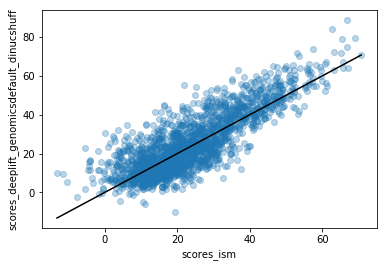

scores_deeplift_rescale_dinucshuff  >  scores_ism pval 7.544145803453571e-28


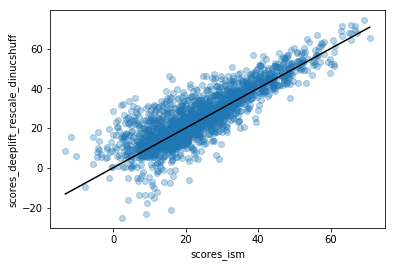

scores_integrated_grad20_dinucshuff  >  scores_ism pval 1.959635925001127e-27


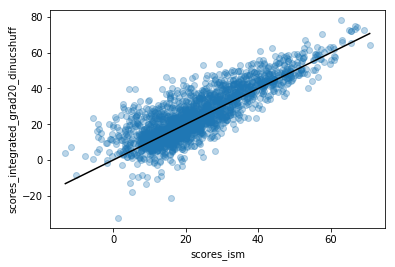

scores_ism  >  scores_grad_times_inp_flatref pval 2.9269698817323965e-130


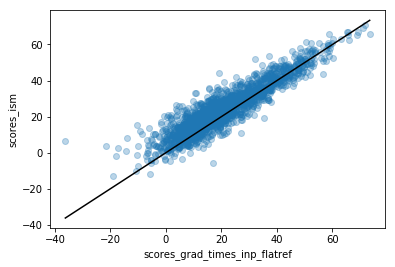

scores_integrated_grad20_dinucshuff  >  scores_deeplift_genomicsdefault_dinucshuff pval 1.7898655154158394e-11


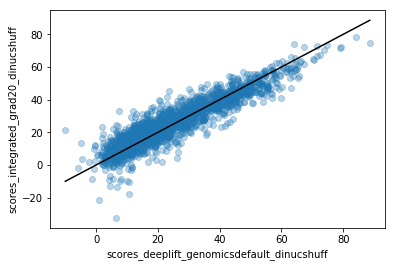

scores_deeplift_genomicsdefault_dinucshuff  >  scores_grad_times_inp_flatref pval 4.7139223522203284e-125


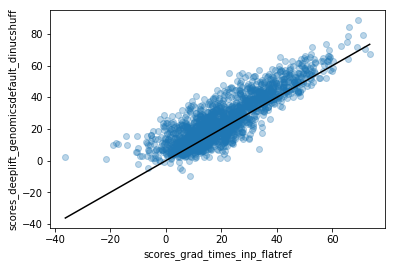

scores_integrated_grad20_dinucshuff  >  scores_deeplift_rescale_dinucshuff pval 0.04033614140241764


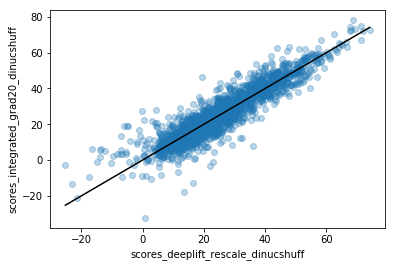

scores_deeplift_rescale_dinucshuff  >  scores_grad_times_inp_flatref pval 1.5752365283967516e-181


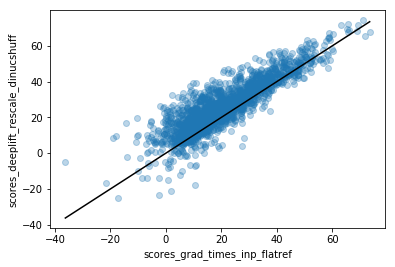

scores_deeplift_rescale_dinucshuff  >  scores_deeplift_genomicsdefault_dinucshuff pval 6.348584480536636e-08


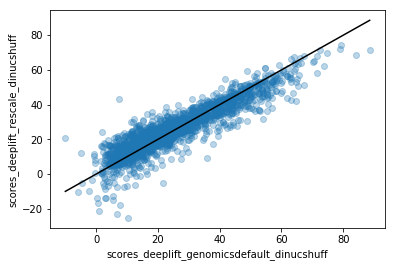

scores_integrated_grad20_dinucshuff  >  scores_grad_times_inp_flatref pval 7.901564312352559e-175


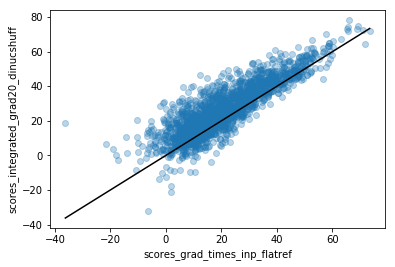

In [66]:
import numpy as np
import random

#dan preinit
#model_prefix = "record_21_model_NZqHC"
#model_prefix = "record_20_model_QFbAM"

model_prefixes_and_folders = [
    #("record_1_model_txak1", "HepG2"),
    #("record_1_model_8E0g9", "GM12878"),
    #("record_1_model_YJQ5u", "K562"),
    ("record_1_model_xIIj6", "A549"),
    #("record_1_model_HICYK", "MCF-7"),
]


#trained from scratch
#model_prefix = "record_15_model_REDP7"

#fcfromscratch
#model_prefix = "record_25_model_Fq78N"
#imp_scores_folder = "imp_scores/fcfromscratch-randinporder"

model_folder_to_subbed_diffs_lookup = {}
model_folder_to_zerod_diffs_lookup = {}
model_folder_to_shuffled_onehot_seqs = {}
model_folder_to_predictive_model = {}
model_folder_to_method_to_tozero = {}

debug_ex_id = 948#

for model_prefix,folder in model_prefixes_and_folders:
    print("\n\n###########\nOn model prefix",folder+"/"+model_prefix,"\n############")
    
    model_weights = folder+"/model_files/"+model_prefix+"_modelWeights.h5"
    model_json = folder+"/model_files/"+model_prefix+"_modelJson.json"

    keras_model = model_from_json(open(model_json).read())
    keras_model.load_weights(model_weights)

    preact_model = Model(inputs=keras_model.input,
                         outputs=keras_model.layers[-2].output)
    model_folder_to_predictive_model[folder] = preact_model

    imp_scores_fh = h5py.File(folder+"/imp_scores_"+model_prefix+".h5", "r")
    onehot_seq = np.array(imp_scores_fh['onehot'])
    orig_preds = preact_model.predict(onehot_seq).squeeze()
    
    print("DEBUG original preds ex_id",debug_ex_id,"is",orig_preds[debug_ex_id])

    seqs = [onehot_to_seq(x) for x in onehot_seq]
    shuffled_onehot_seqs = []
    num_shuffles_to_make = 10
    np.random.seed(1234)
    random.seed(1234)
    for i in range(num_shuffles_to_make):
        shuffled_onehot_seqs.append(np.array(
                [one_hot_encode_along_channel_axis(dinuc_shuffle.dinuc_shuffle(x)) for x in seqs]))
    model_folder_to_shuffled_onehot_seqs[folder] = shuffled_onehot_seqs

    #######Score things
    method_to_zerod_diffs = {}
    method_to_subbed_diffs = {}

    percentile = 80

    scoring_methods = [
        'interspersed',
        'random',
        'scores_ism',
        'scores_deeplift_rescale_dinucshuff',
        'scores_deeplift_genomicsdefault_dinucshuff',
        'scores_integrated_grad20_dinucshuff',
        'scores_grad_times_inp_flatref',

        #'scores_integrated_grad20_avgposref',
        #'scores_deeplift_rescale_avgposref',
        #'scores_deeplift_genomicsdefault_avgposref',
        #'scores_integrated_grad20_flatref',
        #'scores_deeplift_rescale_flatref',
        #'scores_deeplift_genomicsdefault_flatref',

        #'scores_integrated_grad10_dinucshuff',
        #'scores_integrated_grad2_dinucshuff',
        #'scores_integrated_grad5_dinucshuff',     
    ]
    
    method_to_tozero = {}

    for method in scoring_methods:
        #print(method)
        if (method != "interspersed" and method != "random"):
            sys.stdout.flush()
            scores = np.array(imp_scores_fh[method])
            central_scores = scores[:,350:650]

            #for each example, zero out the top 10% of scores

            #to_zero = list(zip(*np.nonzero(central_scores > np.percentile(central_scores,percentile))))
            #print(len(to_zero))
            
            to_zero_unflat = [np.nonzero(ex_central_scores >
                                          np.percentile(ex_central_scores,percentile))[0]
                                          for ex_central_scores in central_scores]  
        else:
            
            num_to_zero = int(300*(1-(percentile/100)))
            if (method=="interspersed"):
                interval_size = int(300/num_to_zero)
                to_zero_unflat = [[i for i in range(int(0.5*interval_size),300,interval_size)]
                                  for x in onehot_seq]
            else:
                assert method=="random"
                to_zero_unflat = [np.random.choice(a=list(range(300)), size=num_to_zero, replace=False)
                                  for x in onehot_seq]
        
        method_to_tozero[method] = to_zero_unflat
        to_zero = [(i,x) for (i,arr) in enumerate(to_zero_unflat) for x in arr]
        print(len(to_zero))

        zerod_inputs = np.array(onehot_seq)
        for example_idx, col_idx in to_zero:
            zerod_inputs[example_idx,350+col_idx] = 0.25

        subbed_inputs_sets = []
        for i in range(num_shuffles_to_make):
            subbed_inputs = np.array(onehot_seq)
            for example_idx, col_idx in to_zero:
                subbed_inputs[example_idx,350+col_idx] = shuffled_onehot_seqs[i][example_idx,350+col_idx]
            subbed_inputs_sets.append(subbed_inputs)
        mean_subbed_preds = np.mean(np.array([preact_model.predict(x).squeeze() for x in subbed_inputs_sets]),axis=0)
        method_to_subbed_diffs[method] = orig_preds-mean_subbed_preds
        print("\navg_diff_meansubbed",method,np.mean(orig_preds-mean_subbed_preds),"num negative:",np.sum(orig_preds-mean_subbed_preds < 0))

        #viz_sequence.plot_weights((onehot_seq[0]*scores[0][:,None])[350:650])
        #viz_sequence.plot_weights((altered_inputs[0]*scores[0][:,None])[350:650])

        zerod_preds = np.squeeze(preact_model.predict(zerod_inputs))
        method_to_zerod_diffs[method] = orig_preds-zerod_preds
        print("avg_diff_zerod",method,np.mean(orig_preds-zerod_preds),"num negative:",np.sum(orig_preds-zerod_preds < 0))

        sys.stdout.flush()
    
    ########Run comparisons
    
    model_folder_to_subbed_diffs_lookup[folder] = method_to_subbed_diffs
    model_folder_to_zerod_diffs_lookup[folder] = method_to_zerod_diffs
    model_folder_to_method_to_tozero[folder] = method_to_tozero

    diffs_lookup = method_to_subbed_diffs    

    #print("Compare to ISM")
    print("\n##Comparisons##\n")

    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_ism",
                    method_2_name="scores_grad_times_inp_flatref",
                    score_lookup=diffs_lookup)

    #print("Comparisons to DeepLIFT")

    compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_grad_times_inp_flatref",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)
    
    compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)
    compare_methods(method_1_name="scores_grad_times_inp_flatref",
                    method_2_name="scores_deeplift_rescale_dinucshuff",
                    score_lookup=diffs_lookup)

    #print("Deeplift revealcancel vs rescale")

    compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                    method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                    score_lookup=diffs_lookup)

    #print("Grad times inp vs intgrad")
    compare_methods(method_1_name="scores_grad_times_inp_flatref",
                    method_2_name="scores_integrated_grad20_dinucshuff",
                    score_lookup=diffs_lookup)
    
    #print("Compare references")
    #compare_methods(method_1_name="scores_integrated_grad20_flatref",
    #                method_2_name="scores_integrated_grad20_dinucshuff",
    #                score_lookup=diffs_lookup)
    #compare_methods(method_1_name="scores_integrated_grad20_avgposref",
    #                method_2_name="scores_integrated_grad20_dinucshuff",
    #                score_lookup=diffs_lookup)
    #compare_methods(method_1_name="scores_deeplift_rescale_flatref",
    #                method_2_name="scores_deeplift_rescale_dinucshuff",
    #                score_lookup=diffs_lookup)
    #compare_methods(method_1_name="scores_deeplift_rescale_avgposref",
    #                method_2_name="scores_deeplift_rescale_dinucshuff",
    #                score_lookup=diffs_lookup)
    #compare_methods(method_1_name="scores_deeplift_genomicsdefault_flatref",
    #                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
    #                score_lookup=diffs_lookup)
    #compare_methods(method_1_name="scores_deeplift_genomicsdefault_avgposref",
    #                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
    #                score_lookup=diffs_lookup)

    #print("Compare different intgrads)
    #compare_methods(method_1_name="scores_integrated_grad2_dinucshuff",
    #                method_2_name="scores_integrated_grad20_dinucshuff",
    #                score_lookup=diffs_lookup)
    #compare_methods(method_1_name="scores_integrated_grad10_dinucshuff",
    #                method_2_name="scores_integrated_grad20_dinucshuff",
    #                score_lookup=diffs_lookup)


In [67]:
import sys

def vis_examples_favoring_method_1(method_1_name, method_2_name,
                                   methods_to_plot,
                                   method_to_tozero,
                                   predictive_model,
                                   shuffled_onehot_seqs,
                                   perf_lookup, imp_scores_fh,
                                   onehot_seq,
                                   num_to_plot=10):
    method_1_perfs = perf_lookup[method_1_name]
    method_2_perfs = perf_lookup[method_2_name]
    method_1_minus_method_2_perfs = method_1_perfs - method_2_perfs
    top_method_1_examples = [x[0] for x in sorted(enumerate(method_1_minus_method_2_perfs),
                                   key=lambda x: -x[1]) if x[1] > 0]
    
    print(len(top_method_1_examples))
    for ex_id in top_method_1_examples[::num_to_plot]:
        print("Example id",ex_id)
        original_pred = predictive_model.predict([[onehot_seq[ex_id]]])
        print(original_pred)
        for method_to_plot in methods_to_plot:
            
            to_zero = [x for x in method_to_tozero[method_to_plot][ex_id]]
            
            shuffled_onehot_seqs_for_ex = [x[ex_id] for x in shuffled_onehot_seqs]
            subbed_out_seqs = []
            for shuffled_onehot_seq in shuffled_onehot_seqs_for_ex:
                subbed_seq = np.array(onehot_seq[ex_id])
                for zero_me in to_zero:
                    subbed_seq[350+zero_me] = shuffled_onehot_seq[350+zero_me]
                subbed_out_seqs.append(subbed_seq)
            subbed_out_preds = predictive_model.predict(np.array(subbed_out_seqs))
            print("mean subbed preds",np.mean(subbed_out_preds))
            print(original_pred-np.mean(subbed_out_preds))
            
            #create zerod-out inputs  
            print(method_to_plot+" diff",perf_lookup[method_to_plot][ex_id])
            print(method_to_plot+" imp scores")
            scores_to_plot = (onehot_seq[ex_id]*imp_scores_fh[method_to_plot][ex_id][:,None])[350:650]
            scores_to_plot_with_zeros = np.zeros_like(scores_to_plot)
            for to_zero_idx in to_zero:
                scores_to_plot_with_zeros[to_zero_idx] = scores_to_plot[to_zero_idx]
                
            viz_sequence.plot_weights(scores_to_plot, subticks_frequency=20)
            viz_sequence.plot_weights(scores_to_plot_with_zeros, subticks_frequency=20)

1148
Example id 948
[[15.476302]]
mean subbed preds 11.24303
[[4.2332726]]
scores_ism diff 4.2332735
scores_ism imp scores


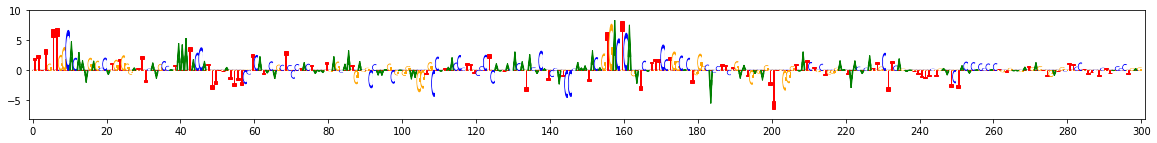

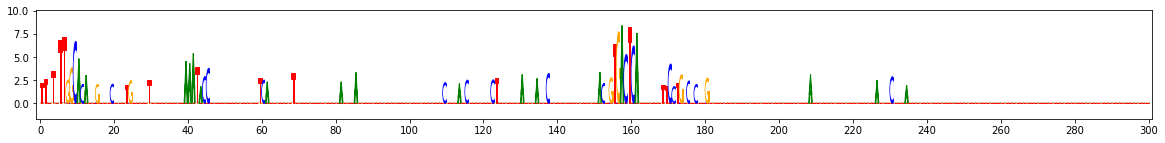

mean subbed preds -18.02258
[[33.498882]]
scores_deeplift_rescale_dinucshuff diff 33.498882
scores_deeplift_rescale_dinucshuff imp scores


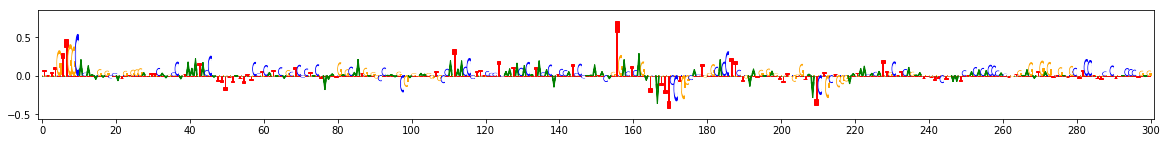

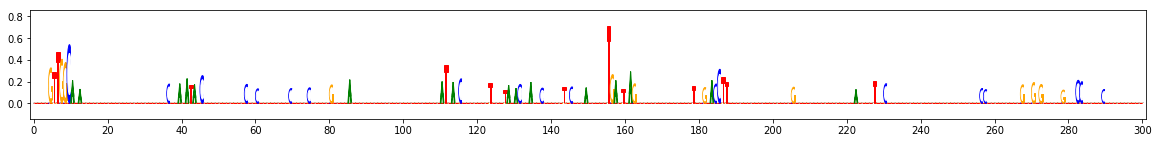

mean subbed preds -24.18803
[[39.664333]]
scores_integrated_grad20_dinucshuff diff 39.664333
scores_integrated_grad20_dinucshuff imp scores


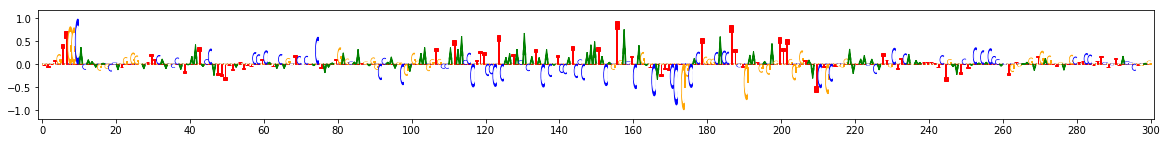

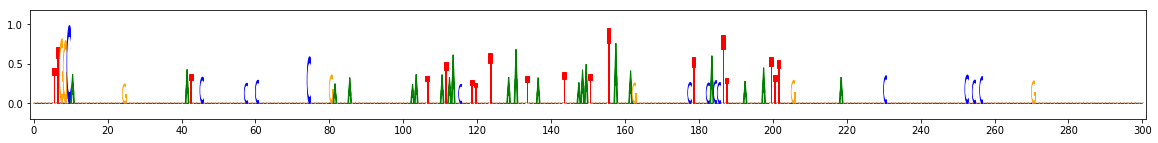

Example id 761
[[7.4836545]]
mean subbed preds 0.027982915
[[7.455672]]
scores_ism diff 7.45567
scores_ism imp scores


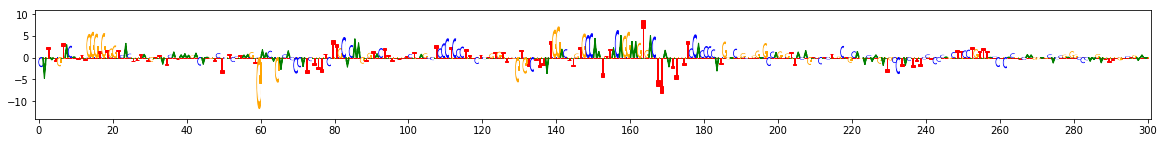

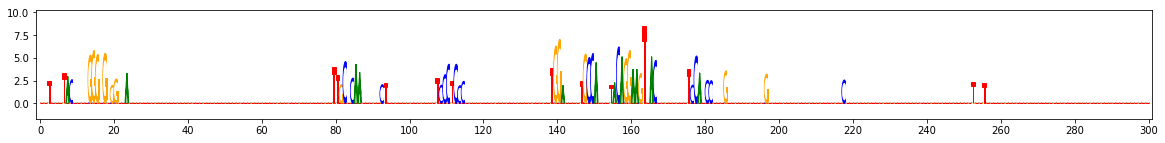

mean subbed preds -21.704914
[[29.188568]]
scores_deeplift_rescale_dinucshuff diff 29.188568
scores_deeplift_rescale_dinucshuff imp scores


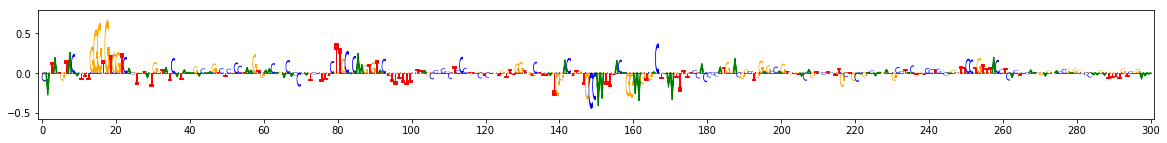

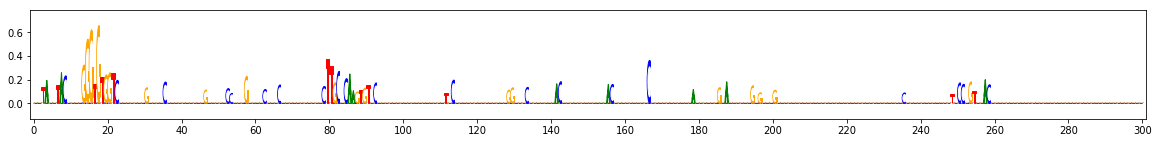

mean subbed preds -25.753256
[[33.23691]]
scores_integrated_grad20_dinucshuff diff 33.236908
scores_integrated_grad20_dinucshuff imp scores


KeyboardInterrupt: 

In [68]:
vis_examples_favoring_method_1(method_1_name="scores_integrated_grad20_dinucshuff",
                               method_2_name="scores_ism",
                               methods_to_plot=["scores_ism",
                                                #"scores_grad_times_inp_flatref",
                                                #"scores_deeplift_genomicsdefault_dinucshuff",
                                                "scores_deeplift_rescale_dinucshuff",
                                                "scores_integrated_grad20_dinucshuff"],
                               method_to_tozero = model_folder_to_method_to_tozero["A549"],
                               predictive_model = model_folder_to_predictive_model["A549"],
                               shuffled_onehot_seqs = model_folder_to_shuffled_onehot_seqs["A549"],
                               perf_lookup=model_folder_to_subbed_diffs_lookup["A549"],
                               imp_scores_fh=h5py.File("A549/imp_scores_record_1_model_xIIj6.h5", "r"),
                               onehot_seq=onehot_seq)